This notebook does initial exploration of the data.

In [52]:
import importlib
import src.imdb_views as imdb_views
import seaborn as sns
import matplotlib.pyplot as plt

_ = importlib.reload(imdb_views)

In [53]:
reader = imdb_views.IMDBDataReader("../../PublicDatasets/IMDB/")

In [54]:
ratings = reader.get_ratings()
title_basics = reader.get_title_basics()

# take intersection of titles with ratings and basic information to reduce the size of the dataset
titles_with_ratings_and_basic_info = \
    ratings[['tconst']].drop_duplicates()\
    .merge(title_basics[['tconst']].drop_duplicates(), on='tconst', how='inner')
ratings = ratings.merge(titles_with_ratings_and_basic_info, on='tconst', how='inner')
title_basics = title_basics.merge(titles_with_ratings_and_basic_info, on='tconst', how='inner')

title_regions = reader.get_title_regions(titles_to_fetch=titles_with_ratings_and_basic_info)

# keep only titles with regions
titles_w_ratings_basic_info_and_regions = \
    titles_with_ratings_and_basic_info\
    .merge(title_regions[['tconst']].drop_duplicates(), on='tconst', how='inner')

ratings = ratings.merge(titles_w_ratings_basic_info_and_regions, on='tconst', how='inner')
title_basics = title_basics.merge(titles_w_ratings_basic_info_and_regions, on='tconst', how='inner')
title_regions = title_regions.merge(titles_w_ratings_basic_info_and_regions, on='tconst', how='inner')

title_to_names = reader.get_title_to_names(titles_to_fetch=titles_w_ratings_basic_info_and_regions)

Time taken to read ratings data: 0.6358146667480469 seconds
Time taken to read title basics data: 18.615596771240234 seconds
Time taken to read title regions data: 69.61427640914917 seconds
Time taken to compute the final title to names dataframe: 1.9435299237569172 mins


pick a few random titles, names, ratings, etc. to see if they match the official imdb website to ensure the data is correct.

In [55]:
# pick a random title
title_id = title_basics.sample(1)['tconst'].iloc[0]
print (title_id)
print ("\n\n")
print (ratings.query('tconst == @title_id'))
print ("\n\n")
print (title_basics.query('tconst == @title_id'))
print ("\n\n")
print (title_regions.query('tconst == @title_id'))
print ("\n\n")
print (title_to_names.query('tconst == @title_id'))
print ("\n\n")
print ("https://www.imdb.com/title/" + title_id)

tt2477178



           tconst  averageRating  numVotes
214616  tt2477178            7.2        16



           tconst titleType primaryTitle isAdult startYear runtimeMinutes  \
214616  tt2477178     movie        Hitch       0      2012             70   

       genres  
214616  Drama  



            tconst  region language
1134527  tt2477178  France   French
1134528  tt2477178      UK  English
1134529  tt2477178  France      ALL
1134530  tt2477178      UK      ALL



            tconst  category      primaryName
623874   tt2477178     actor    Féodor Atkine
630965   tt2477178     actor   Thomas Chabrol
820061   tt2477178  director  Sébastien Grall
866426   tt2477178     actor     Joe Sheridan
912952   tt2477178   actress    Patty Hannock
2342219  tt2477178     actor   Mathieu Bisson



https://www.imdb.com/title/tt2477178


check distrubtions of ratings, votes, title counts, etc. per region, language, genere, etc.

In [56]:
print ("Number of titles in different datasets")
print (f"ratings -> {len(ratings)} ({ratings['tconst'].nunique()} unique)")
print (f"title_basics -> {len(title_basics)} ({title_basics['tconst'].nunique()} unique)")
print (f"title_regions -> {title_regions['tconst'].nunique()} unique")
print (f"title_to_names -> {title_to_names['tconst'].nunique()} unique")

Number of titles in different datasets
ratings -> 299173 (299173 unique)
title_basics -> 299173 (299173 unique)
title_regions -> 299173 unique
title_to_names -> 281881 unique


<Axes: xlabel='region', ylabel='tconst'>

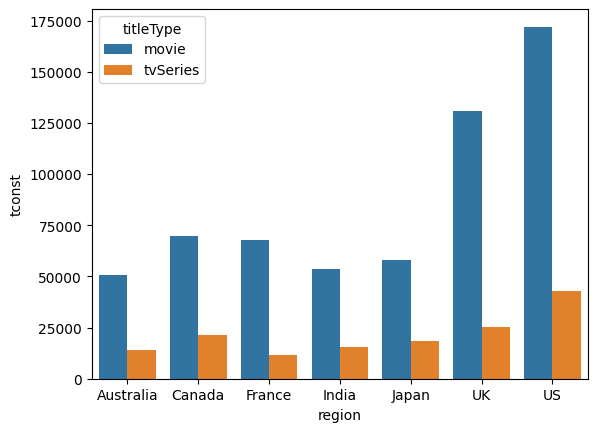

In [57]:
# how many movies / shows are there in each region
plot_data = title_regions.query('language == "ALL"')\
    .merge(title_basics[['tconst', 'titleType']], on='tconst', how='inner')\
    .groupby(['region', 'titleType'])[['tconst']]\
    .count()\
    .reset_index()

sns.barplot(x='region', y='tconst', hue='titleType', data=plot_data)

# ok. each region has at least 50k movies
# tv shows are much fewer than movies as expected

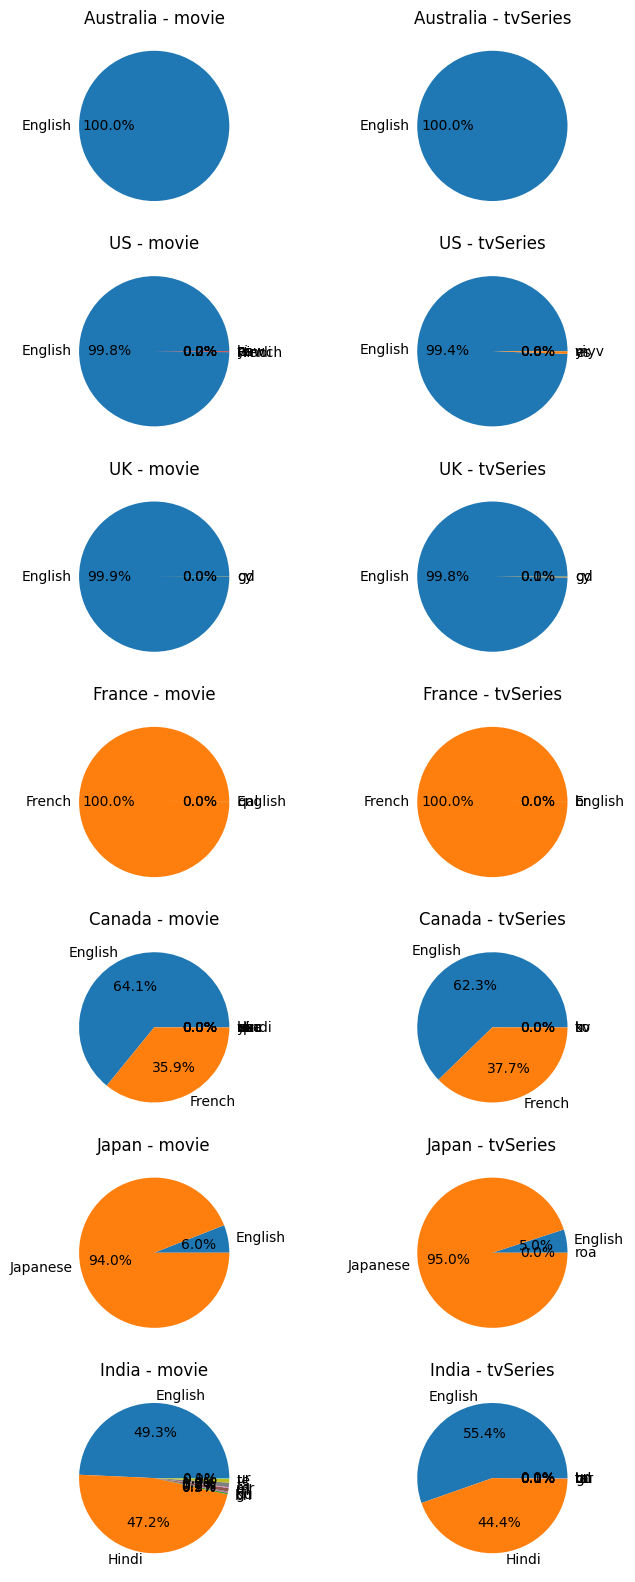

In [58]:
# what is the language share of movies and shows in each region
# plot a pie chart for each region and title type
# create a grid of plots with 2 columns (for title types) and as many rows as there are regions
regions = title_regions['region'].unique()
title_types = ['movie', 'tvSeries']

fig, axs = plt.subplots(len(regions), len(title_types), figsize=(8, 20))

title_regions_with_types = title_regions\
    .merge(title_basics[['tconst', 'titleType']], on='tconst', how='inner')
for i, region in enumerate(regions):
    for j, title_type in enumerate(title_types):
        plot_data = title_regions_with_types\
            .query('language != "ALL"')\
            .query('region == @region and titleType == @title_type')\
            .groupby('language')[['tconst']]\
            .count()\
            .reset_index()

        axs[i, j].pie(plot_data['tconst'], labels=plot_data['language'], autopct='%1.1f%%')
        axs[i, j].set_title(f"{region} - {title_type}")

plt.show()

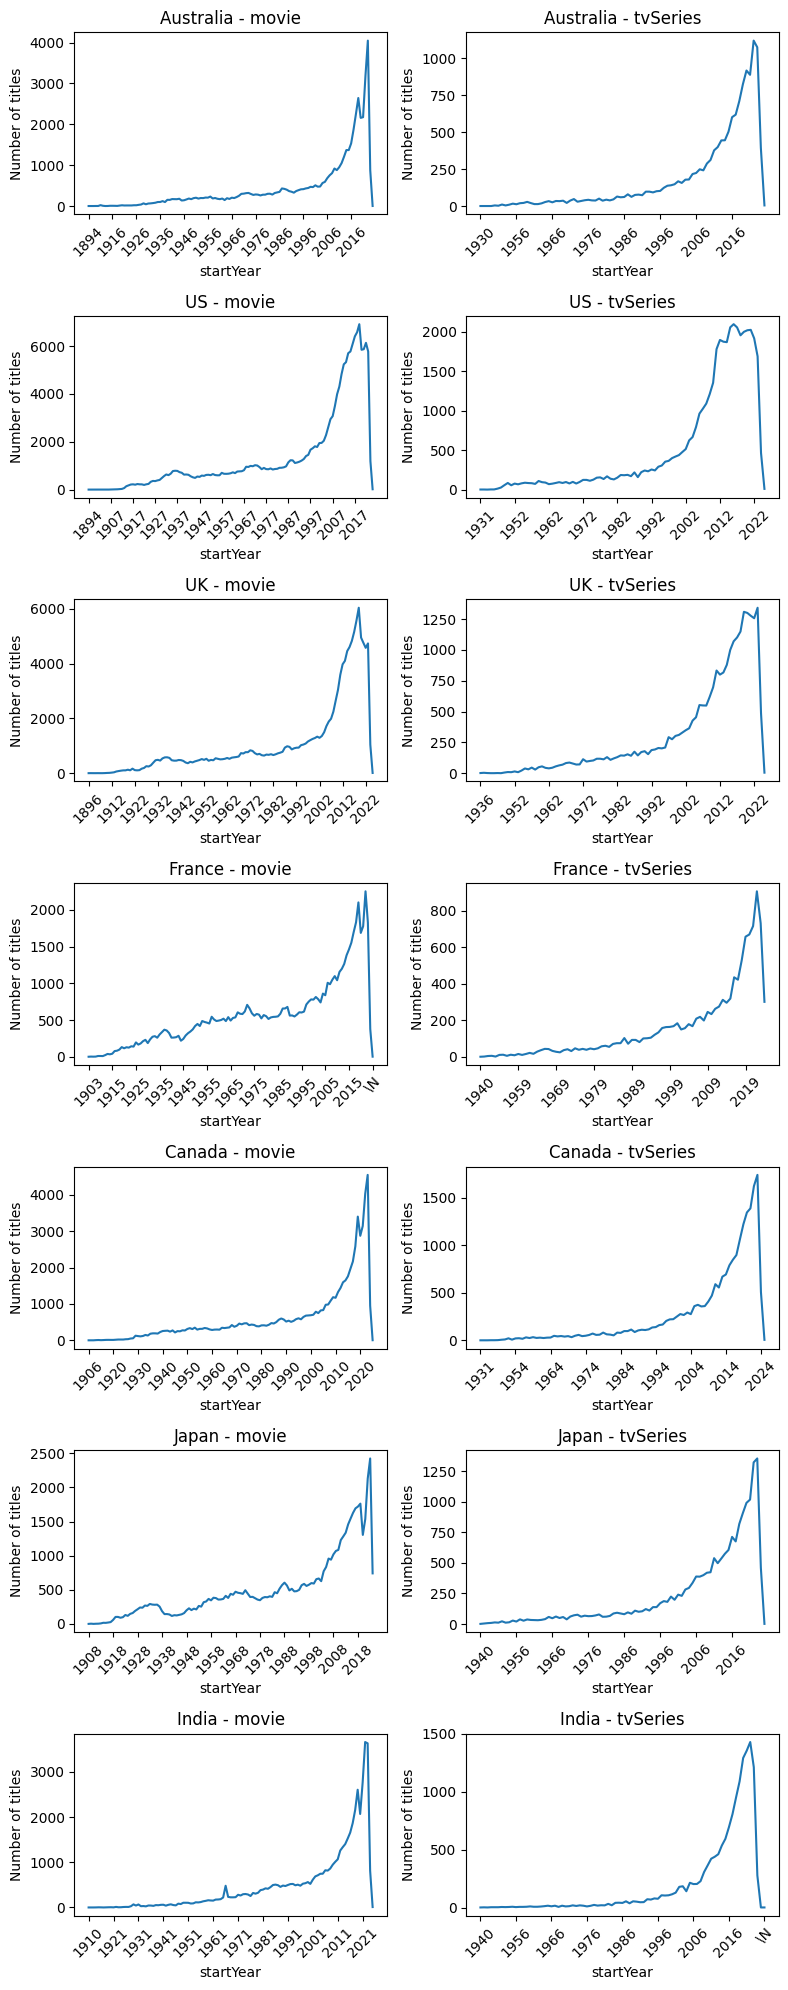

In [67]:
# plot number of titles over time for each region and title type
# create a grid of plots with 2 columns (for title types) and as many rows as there are regions

regions = title_regions['region'].unique()
title_types = ['movie', 'tvSeries']

fig, axs = plt.subplots(len(regions), len(title_types), figsize=(8, 20))

title_regions_with_types = title_regions\
    .merge(title_basics[['tconst', 'titleType', 'startYear']], on='tconst', how='inner')

for i, region in enumerate(regions):
    for j, title_type in enumerate(title_types):
        plot_data = title_regions_with_types\
            .query('language == "ALL"')\
            .query('region == @region and titleType == @title_type')\
            .groupby('startYear')[['tconst']]\
            .count()\
            .reset_index()

        sns.lineplot(x='startYear', y='tconst', data=plot_data, ax=axs[i, j])
        # show only every 10th year on x-axis
        axs[i, j].set_xticks(plot_data['startYear'].unique()[::10])
        # rotate x-axis labels
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45)
        axs[i, j].set_title(f"{region} - {title_type}")
        # set y-axis label
        axs[i, j].set_ylabel("Number of titles")

plt.tight_layout()
plt.show()

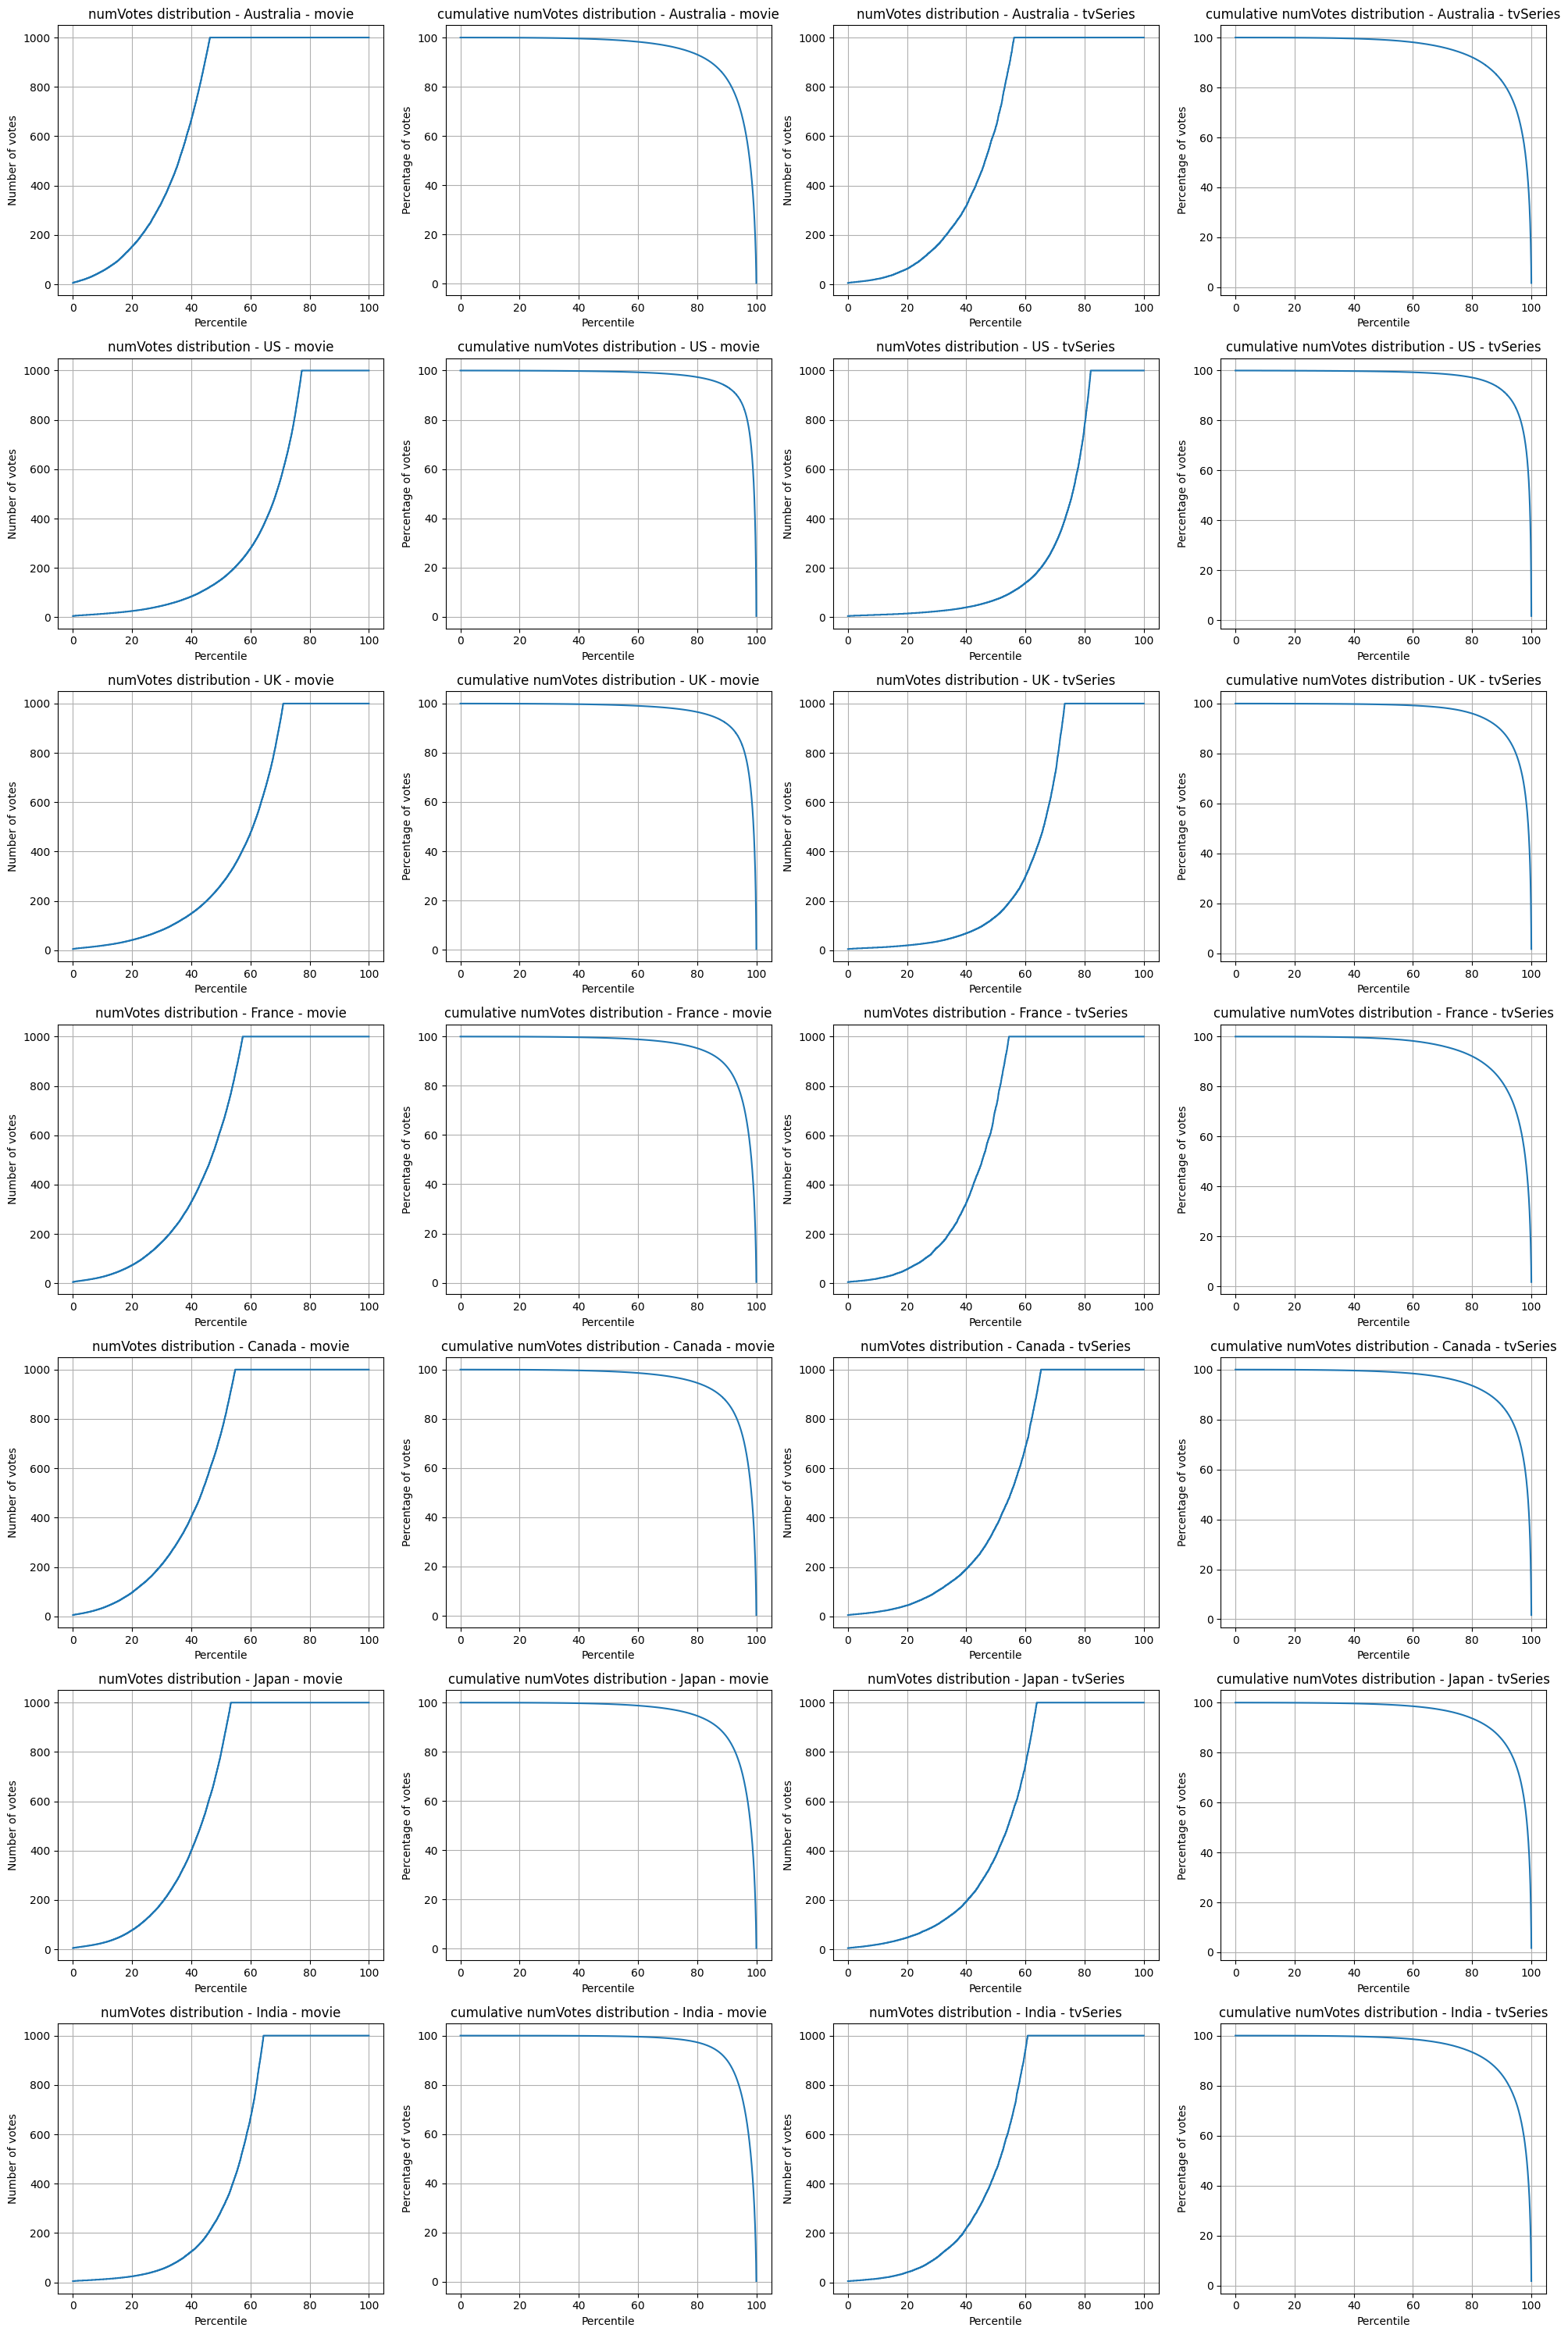

In [80]:
"""
show point and cummulative distribution of number of votes in each region and title type
create a grid of plots with 4 columns and as many rows as there are regions
column 1 - x-axis is percentile (1 to 100) where the title stands based on number of votes (sorted descding)
    and y-axis is number of votes at that percentile
column 2 - x-axis is percentile (1 to 100) where the title stands based on number of votes (sorted descding)
    and y-axis is the percentage of votes that the titles in that percentile have
    as compared to all votes in the region
column 3 and 4 are the same as 1 and 2 but for tv shows
"""

regions = title_regions['region'].unique()
title_types = ['movie', 'tvSeries']

fig, axs = plt.subplots(len(regions), 4, figsize=(20, 30))

title_regions_with_types = title_regions\
    .merge(ratings[['tconst', 'numVotes']], on='tconst', how='inner')\
    .merge(title_basics[['tconst', 'titleType']], on='tconst', how='inner')

for i, region in enumerate(regions):
    for j, title_type in enumerate(title_types):
        plot_data = title_regions_with_types\
            .query('language == "ALL"')\
            .query('region == @region and titleType == @title_type')\
            .sort_values('numVotes', ascending=False)
        plot_data['percentile'] = 100 * plot_data['numVotes'].rank(pct=True, method='first')
        plot_data['cumulative_percent'] = 100 * plot_data['numVotes'].cumsum() / plot_data['numVotes'].sum()

        # clip numVotes to be able to see the distribution for small values better
        plot_data['numVotes'] = plot_data['numVotes'].apply(lambda x: min(x, 1000))
        sns.lineplot(x='percentile', y='numVotes', data=plot_data, ax=axs[i, 2*j])
        axs[i, 2*j].set_title(f"numVotes distribution - {region} - {title_type}")
        axs[i, 2*j].set_xlabel("Percentile")
        axs[i, 2*j].set_ylabel("Number of votes")
        axs[i, 2*j].grid()

        sns.lineplot(x='percentile', y='cumulative_percent', data=plot_data, ax=axs[i, 2*j+1])
        axs[i, 2*j+1].set_title(f"cumulative numVotes distribution - {region} - {title_type}")
        axs[i, 2*j+1].set_xlabel("Percentile")
        axs[i, 2*j+1].set_ylabel("Percentage of votes")
        axs[i, 2*j+1].grid()

plt.tight_layout()
plt.show()


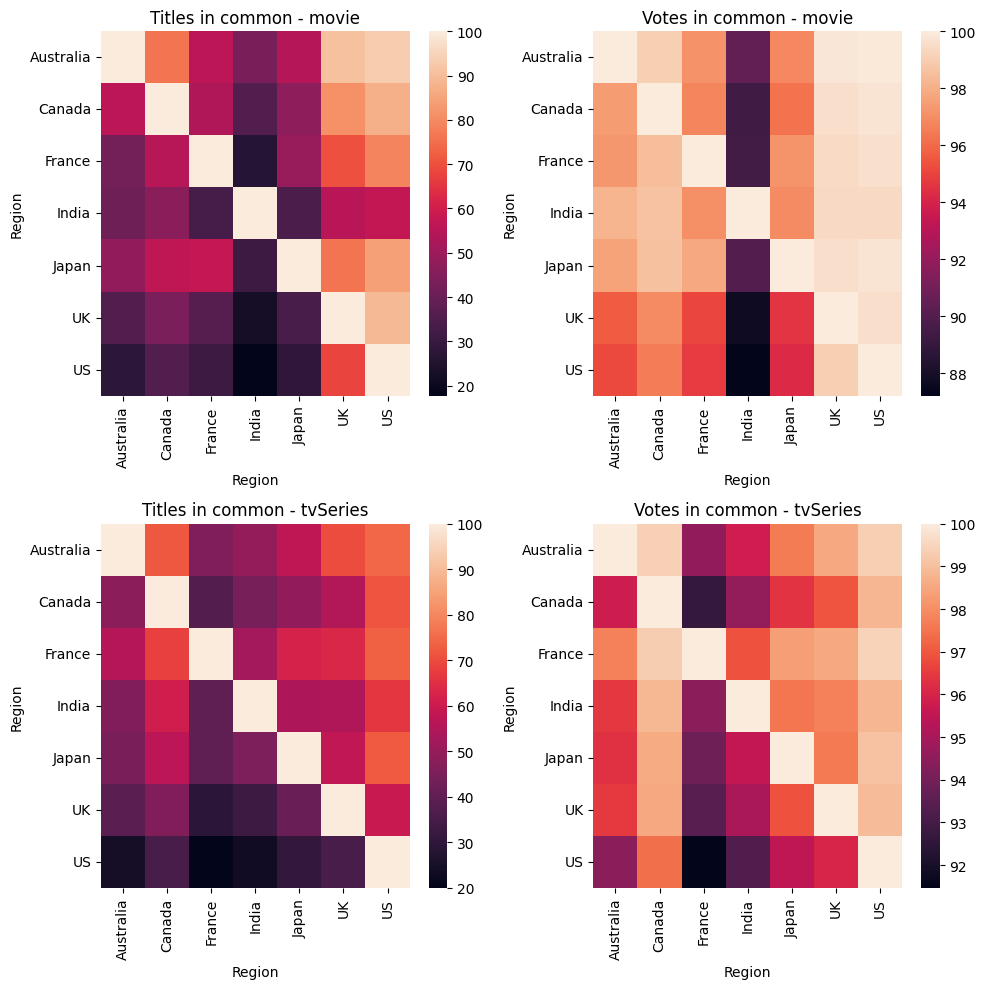

In [86]:
# what percentage of titles and votes are shared between regions?
# do titles tend to be released in only one region or multiple regions?
# show 4 heat maps
# 1 where M[i, j] = percentage of movies in region i that are also in region j
# 2 where M[i, j] = percentage of movie votes in region i that are also in region j
# 3 and 4 are the same as 1 and 2 but for tv shows

regions = title_regions['region'].unique()
title_types = ['movie', 'tvSeries']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

title_regions_with_types = title_regions\
    .query('language == "ALL"')\
    .merge(ratings[['tconst', 'numVotes']], on='tconst', how='inner')\
    .merge(title_basics[['tconst', 'titleType']], on='tconst', how='inner')

for i, title_type in enumerate(title_types):
    title_level_stats = title_regions_with_types\
        .query('titleType == @title_type')\
        [['tconst', 'region', 'numVotes']]
    region_level_stats = title_level_stats\
        .groupby('region')\
        .agg({'tconst': 'count', 'numVotes': 'sum'})\
        .reset_index()\
        .rename(columns={'tconst': 'numTitlesInTotal', 
                         'numVotes': 'numVotesInTotal', 
                         'region': 'region1'})
    region_to_region_stats = title_level_stats\
        .rename(columns={'region': 'region1'})\
        .merge(title_level_stats
            .rename(columns={'region': 'region2'})
            [['tconst', 'region2']], on='tconst', how='inner')\
        .groupby(['region1', 'region2'])\
        .agg({'tconst': 'count', 'numVotes': 'sum'})\
        .reset_index()\
        .rename(columns={'tconst': 'numTitles', 'numVotes': 'numVotes'})\
        .merge(region_level_stats, on='region1', how='inner')
        
    region_to_region_stats['percentTitlesInCommon'] = 100 * region_to_region_stats['numTitles'] / region_to_region_stats['numTitlesInTotal']
    region_to_region_stats['percentVotesInCommon'] = 100 * region_to_region_stats['numVotes'] / region_to_region_stats['numVotesInTotal']

    plot_data = region_to_region_stats.pivot(index='region1', columns='region2', values='percentTitlesInCommon')
    sns.heatmap(plot_data, ax=axs[i, 0])
    axs[i, 0].set_title(f"Titles in common - {title_type}")
    axs[i, 0].set_xlabel("Region")
    axs[i, 0].set_ylabel("Region")

    plot_data = region_to_region_stats.pivot(index='region1', columns='region2', values='percentVotesInCommon')
    sns.heatmap(plot_data, ax=axs[i, 1])
    axs[i, 1].set_title(f"Votes in common - {title_type}")
    axs[i, 1].set_xlabel("Region")
    axs[i, 1].set_ylabel("Region")

plt.tight_layout()
plt.show()


There is too much overlap between the titles across regions. Especially in big titles with more votes.
This means that if we picked top titles from each region, we would get pretty much the same titles.
We need a way to assign each title to a unique region of origin to get informative top-K titles per region.